In [1]:
import os
import sys
import time

verbose  = os.environ.get('RADICAL_PILOT_VERBOSE', 'REPORT')
os.environ['RADICAL_PILOT_VERBOSE'] = verbose

import radical.pilot as rp
import radical.utils as ru

from rose.learner import ParallelExperience
from rose.engine import Task, ResourceEngine
from rose.metrics import GREATER_THAN_THRESHOLD

In [2]:
engine = ResourceEngine({'runtime': 30,
                         'resource': 'local.localhost'})
pe = ParallelExperience(engine)
code_path = f'{sys.executable} {os.getcwd()}'
data_path = os.path.join(os.getcwd(), 'data')
os.makedirs(data_path, exist_ok=True)

Resource Engine started successfully

Task 'environment_2' ready to submit; resolved dependencies: []
Task 'environment_1' ready to submit; resolved dependencies: []
Task 'environment_5' ready to submit; resolved dependencies: []
Task 'environment_4' ready to submit; resolved dependencies: []
Task 'environment_3' ready to submit; resolved dependencies: []
submitting ['environment_2', 'environment_1', 'environment_5', 'environment_4', 'environment_3'] for execution
task.000001 is DONE
task.000000 is DONE
task.000004 is DONE
task.000003 is DONE
task.000002 is DONE
Task 'merge' ready to submit; resolved dependencies: []
submitting ['merge'] for execution
task.000005 is DONE
Task 'update' ready to submit; resolved dependencies: ['merge']
submitting ['update'] for execution
task.000006 is DONE
Task 'check_reward' ready to submit; resolved dependencies: ['update']
submitting ['check_reward'] for execution
task.000007 is DONE
Task 'environment_4' ready to submit; resolved dependencies: []
Tas

In [3]:
# Define and register the environment tasks
@pe.environment_task(name='env_1')
def environment_1(*args):
    return Task(executable=f'{code_path}/environment.py {data_path} replay_memory_1.pkl', arguments=args)

@pe.environment_task(name='env_2')
def environment_2(*args):
    return Task(executable=f'{code_path}/environment.py {data_path} replay_memory_2.pkl', arguments=args)

@pe.environment_task(name='env_3')
def environment_3(*args):
    return Task(executable=f'{code_path}/environment.py {data_path} replay_memory_3.pkl', arguments=args)

@pe.environment_task(name='env_4')
def environment_4(*args):
    return Task(executable=f'{code_path}/environment.py {data_path} replay_memory_4.pkl', arguments=args)

@pe.environment_task(name='env_5')
def environment_5(*args):
    return Task(executable=f'{code_path}/environment.py {data_path} replay_memory_5.pkl', arguments=args)

@pe.merge_task
def merge(*args):
    return Task(executable=f'{code_path}/merge_memory.py {data_path}', arguments=args)

# Define and register the policy update task
@pe.update_task
def update(*args):
    return Task(executable=f'{code_path}/update.py {data_path}', arguments=args)

@pe.as_stop_criterion(metric_name='MODEL_REWARD', threshold=200, operator=GREATER_THAN_THRESHOLD)
def check_reward(*args):
    return Task(executable=f'{code_path}/check_reward.py {data_path}', arguments=args)

In [4]:
env_1 = environment_1()
env_2 = environment_2()
env_3 = environment_3()
env_4 = environment_4()
env_5 = environment_5()
mer = merge()
upd = update()
stop_cond = check_reward()

In [5]:
pe.learn()

Starting Iteration-0
Registered task 'environment_1' and id of 000000 with dependencies: []
Registered task 'environment_2' and id of 000001 with dependencies: []
Registered task 'environment_3' and id of 000002 with dependencies: []
Registered task 'environment_4' and id of 000003 with dependencies: []
Registered task 'environment_5' and id of 000004 with dependencies: []
Registered task 'merge' and id of 000005 with dependencies: []
Registered task 'update' and id of 000006 with dependencies: ['merge']
Registered task 'check_reward' and id of 000007 with dependencies: ['update']
stop criterion metric: MODEL_REWARD is not met yet (9.33).
Starting Iteration-1
Registered task 'environment_1' and id of 000008 with dependencies: []
Registered task 'environment_2' and id of 000009 with dependencies: []
Registered task 'environment_3' and id of 000010 with dependencies: []
Registered task 'environment_4' and id of 000011 with dependencies: []
Registered task 'environment_5' and id of 000012

In [6]:
engine.shutdown()

Shutdown is triggered, terminating the resources gracefully


Text(0.5, 1.0, 'Reward Values for Cart Pole')

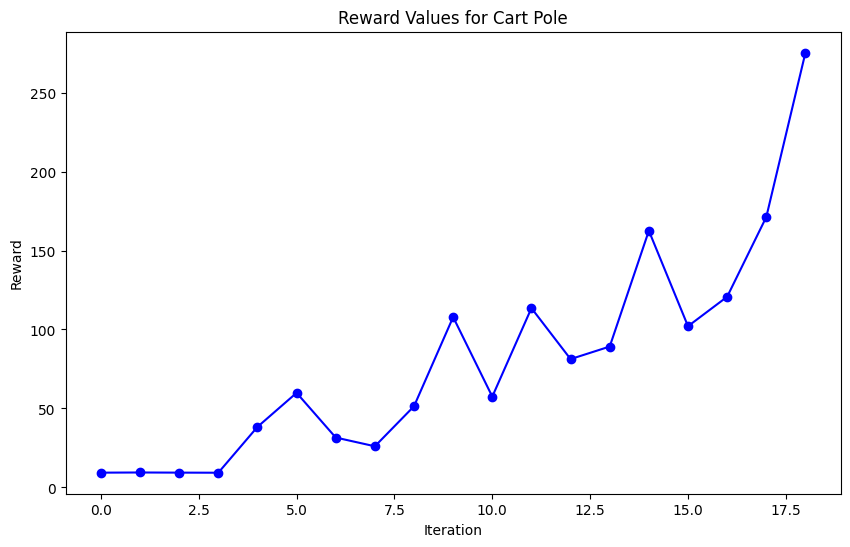

In [7]:
import matplotlib.pyplot as plt
reward_values = pe.get_result(task_name='check_reward')
reward_values = [float(reward.strip()) for reward in reward_values]

plt.figure(figsize=(10, 6))
plt.plot(reward_values, marker='o', color='b', linestyle='-', markersize=6)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward Values for Cart Pole')